In [11]:
from glob import glob
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# The True T_eff is different between the RNN and the RF data. LOOK at the problem

In [69]:
base_path = '../../../CV_c/01_CreateFolds/PanStarrs/Folds/'
test_path = join(base_path, 'test.csv')
test = pd.read_csv(test_path)
test.drop(['index'], axis=1, inplace=True)
test.rename({'ID':'oid'}, axis=1, inplace=True)
test = test.set_index('oid')
test = test[['T_eff', 'Radius']]

Load the results per survey

In [70]:
survey = 'PanStarrs'
# survey = 'Gaia'
# survey = 'ZTF'
results_rnn = glob('../04_ComputeMetrics/{}/Results/*'.format(survey))
results_rnn.sort()
# results_rnn

In [71]:
results_rf = glob('../../../../../../BRF_baseline/experiments/regression/{}/results/*'.format(survey))
results_rf.sort()
# results_rf

In [72]:
# Get the first fol for RNN and RF
result_rf = pd.read_csv(results_rf[1]).set_index('oid')
result_rnn = pd.read_csv(results_rnn[0], usecols=['True_T_eff'])

In [73]:
df1 = pd.merge(test, result_rnn, left_index=True, right_index=True)
df2 = pd.merge(test, result_rf, left_index=True, right_index=True)
print('Differente for RNN: {:.2f} and for RF: {:.2e}'.format(np.mean(df1['T_eff']-df1['True_T_eff']), np.mean(df2['T_eff']-df2['True_T_eff']) ))

Differente for RNN: -76.93 and for RF: -9.96e-16


Check radius too

In [74]:
# Get the first fol for RNN and RF
result_rf = pd.read_csv(results_rf[0]).set_index('oid')
result_rnn = pd.read_csv(results_rnn[0])#, usecols=['True_Radius'])

In [77]:
param = 'Radius'
df1 = pd.merge(test, result_rnn, left_index=True, right_index=True)
df2 = pd.merge(test, result_rf, left_index=True, right_index=True)
print('Differente for RNN: {:.2f} and for RF: {:.2e}'.format(np.mean(df1[param]-df1['True_'+param]), np.mean(df2[param]-df2['True_'+param]) ))

Differente for RNN: 1.90 and for RF: -3.06e-17


Clearly, the RNN is at fault. Load the RNN data and investigate


In [10]:
train_args = {
            'hidden_size_bands':[64, 64, 64],
            'hidden_size_central':[64, 64, 64],
            'fc_layers_bands':[128,128],
            'fc_layers_central':[128,128], # Neurons of each layer
            'regression_size':[128, 128],#each element is a layer with that size.
            'buffer_size':10000,
            'epochs':1000,
            'num_threads':7,
            'batch_size':512,
            'dropout':0.35,
            'lr':[[5e-3]*5, 2.5e-3], # [[band1, band2], central]
            'val_steps':50,
            'max_to_keep':0, # Not Used 
            'steps_wait':500, 
            'use_class_weights':False,# Not Used
            'mode' : 'classifier+regression',
            }
# loss_weights = {'Class':300.0, 'T_eff':1.0,'Radius':1e0}
loss_weights = {'Class':300.0, 'T_eff':20.0,'Radius':1e0}

callbacks_args = {'patience': 20,
                  'mode':'max',
                  'restore_best_weights':True,
                  'min_delta': 0.001
                 }
train_args_specific={
                    'phys_params': ['T_eff', 'Radius'],
                    'use_output_bands' : True,  # Working
                    'use_output_central' : False, # Not used
                    'use_common_layers' : False, # NOT Working
                    'bidirectional_central' : False,# Working
                    'bidirectional_band' : False,# Not Working
                    'layer_norm_params' : None, # Used to normalyze common layers
                    'use_gated_common' : False, # Working
                    'l1':0.0,
                    'l2':0.0,
                    'N_skip' : 2, # Cannot be greater than the number of timesteps
                    'use_raw_input_central': False,
                    'train_steps_central' : 1,
                    'print_report' : True,
                    'loss_weights_central' : loss_weights,
                    'callbacks_args':callbacks_args    
                    }



In [89]:
# for fold in folds:
#     tf.keras.backend.clear_session()
#     # Set the fold path
#     base_dir = fold+'/'

#     # Set the save path for this fold. Create folder if needed
#     path_results_fold = fold.replace('../02_CreateRecords/'+survey+'/', './').replace('/Folds/', '/Results/')
#     if not os.path.exists(path_results_fold):
#         os.mkdir(path_results_fold)
        
#     train_args_specific['save_dir'] = path_results_fold
#     train_args_specific['metadata_pre_path'] = base_dir+'metadata_preprocess.json'
#     train_args_specific['path_scalers'] =  os.path.join(fold,'scalers')
#     # Define the train args
#     train_args = {**train_args, **train_args_specific}


#     train_files = base_dir+'train/*.tfrecord'
#     val_files = base_dir+'val/*.tfrecord'
#     test_files = base_dir+'test/*.tfrecord'

#     new = multiband.Network()
#     new.train(train_args, train_files, val_files, test_files)
#     # new.train_loop()

In [90]:
param = 'T_eff'
dfs = []
for file_rf in results_rf:
    if param not in file_rf:
        continue
    result_rf = pd.read_csv(file_rf)
    for file_rnn in results_rnn:
        result_rnn = pd.read_csv(file_rnn)

        df =pd.merge(result_rnn, result_rf, left_index=True, right_index=False, right_on='oid')
        dfs.append(df)

In [91]:
df = dfs[0]
df2 = df[[i for i in df.columns if 'T_eff' in i]]

In [92]:
df

,Prob_RRC,Prob_T2CEP,Prob_RRD,Prob_MIRA_SR,Prob_RRAB,Prob_DSCT_SXPHE,Class,Pred,True_T_eff_x,Pred_T_eff_x,True_Radius,Pred_Radius,oid,True_T_eff_y,Pred_T_eff_y
747,0.963807,1.578033e-04,0.031980,4.187120e-06,3.960753e-03,9.083281e-05,RRC,RRC,7396.3037,7270.9070,-1.0,13.418306,84300158481827892,7385.0000,7411.518844
1885,0.000019,3.045983e-05,0.000358,1.865065e-06,9.995723e-01,1.841904e-05,RRAB,RRAB,5955.7760,6234.9897,-1.0,8.359905,74163190788076994,5957.0000,6277.337238
141,0.999497,1.891758e-05,0.000256,1.555396e-05,1.168636e-04,9.621263e-05,RRC,RRC,6638.7150,5767.8823,-1.0,13.194317,103253008374854869,6634.0000,6169.763946
1145,0.971100,1.071001e-04,0.012762,5.273598e-06,1.596931e-02,5.726083e-05,RRC,RRC,7203.6280,6730.8330,-1.0,13.048449,74022884304620926,7194.0000,6751.107181
1400,0.030366,1.202765e-04,0.001657,5.324930e-06,9.678507e-01,3.914358e-07,RRAB,RRAB,6253.8680,5624.9033,-1.0,8.247026,131542740608734400,6252.5000,5847.198352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202,0.999920,2.318662e-07,0.000004,8.647956e-07,4.950754e-07,7.425876e-05,RRC,RRC,7193.5400,7321.1860,-1.0,18.031153,119763092193972840,7184.0000,7220.568487
1257,0.000010,1.090309e-05,0.000057,1.592012e-05,9.999057e-01,2.213422e-07,RRAB,RRAB,4935.4830,5322.0770,-1.0,13.331713,101412581530053985,4945.5800,4974.371120
2118,0.999767,1.478096e-06,0.000037,1.395068e-06,7.284782e-06,1.863156e-04,RRC,RRC,5179.1553,5620.3086,-1.0,10.607086,88030993986271827,5187.1333,5680.595427
3255,0.000037,3.702727e-01,0.000319,2.581022e-02,6.035540e-01,7.251919e-06,RRAB,RRAB,5699.5474,5720.7590,-1.0,8.869767,98612894834983456,5703.0000,5582.243354


In [93]:
def split_experiments(results):
    """Split the experiments for each physical parameter."""

    # Use th efirst fold as a guide
    res = [result for result in results if "Fold_1" in result]
    # Get the different physical parameters
    # First select the filename
    params_files = [i.split('/')[-1] for i in res]
    # Then find "Fold_1_" and select everything after that
    params = [i.partition('Fold_1_')[2].split('.')[0] for i in params_files]
    # For each param, create a list. Keys are the params
    exp_lists = dict.fromkeys(params,[])
    for param in params:
        exp_lists[param] = [i for i in results if param in i]
        # Sort them to start from the first
        exp_lists[param].sort()
    return exp_lists, params


Estimate the median of each prediction

In [7]:
def get_cols(df, params):
    """Extracts the pred and true physical parameters."""
    # Columns containing the relevant information
    cols = ['Pred_','True_']
    df = df[[p+i for i in params for p in cols]]
    return df

In [8]:
def check_index(df, index_name):
    """Check if the index is index_name, if it is not, assigns it."""
    
    # Check if oid is one of the columns
    if index_name in df.columns:
        # Change the index to be an int
        df[index_name] = df[index_name].astype(int)
        # Set is as the index
        df = df.set_index(index_name)
    return df
def prepare_files(results, index_name='oid'):
    # Read the first DataFrame to include data here
    dfs = pd.read_csv(results[0])
    # Checks index
    dfs = check_index(dfs, index_name)    
    # Get the column names
    columns = dfs.columns
    # Only extract the columns with physical parameters
    params = ['_'.join(i.split('_')[1:]) for i in columns if 'Pred_' in i]
    # Get the true and predicted values
    dfs = get_cols(dfs, params)
    # only get the predictions
    sel_params = ['Pred_'+param for param in params]
    # Iterate over all the folds to create a single dataframe
    for i,result in enumerate(results[1:], start=1):
        # reads the data, assumes index is written
        df = pd.read_csv(result)
        # Checks index
        df = check_index(df, index_name)
        df = get_cols(df, params)
        dfs = pd.merge(dfs, df[sel_params], how='inner', left_index=True, right_index=True,suffixes=('','_'+str(i)))    
    return dfs, params


In [9]:
def get_results(results_list, from_rf=False):

    # process the files for the RF
    if from_rf:
        # Extract each physical parameter's result file list
        results_rf, params = split_experiments(results_list)
        # Process each one individually
        print(results_rf.keys())
        dfs = dict.fromkeys(params)
        # df = read_single_file(file_path)
        # if df is not None:
        #     dfs_for_key.append(df)        
        for param in params:
            print(param)
            # Get the param, ignore the second output (same param)
            dfs,_ = prepare_files(results_rf[param])
            # dfs[param] = dfs[param].merge(df, left_index=True, right_index=True)
        # Join them, column wise (axis1)
        # dfs = 
    else:
        # Process the files for the rnn
        dfs,params = prepare_files(results_list)
    # Compute the median and mean, per parameter
    output_df = dfs[[i for i in dfs.columns if 'True_' in i]].copy()
    for param in params:
        # Select only the predicted columns
        pred_cols_param = [col for col in dfs.columns if 'Pred_'+param in col]
        sel = dfs[pred_cols_param]
        # Get the statistics
        median = sel.median(axis=1)
        mean = sel.mean(axis=1)
        # Output the dataframe
        output_df = output_df.assign(**{'median_'+param:median ,
                                        'mean_'+param: mean})
    return output_df
# output_df.head()

## For  T_eff

In [ ]:
# Define the parameter
param = 'T_eff'
n_bins =15

In [41]:
rf

,True_T_eff,median_Radius,mean_Radius,median_T_eff,mean_T_eff
oid,,,,,
90752870729198448,6033.0000,NaN,NaN,6399.623655,6404.235939
111850650934828506,6731.0000,NaN,NaN,6415.798537,6416.657746
115542702349595209,5990.3335,NaN,NaN,6674.773728,6676.001342
74652707998828066,4777.0000,NaN,NaN,5251.882830,5245.051363
108932907287826790,3850.7400,NaN,NaN,3892.319051,3889.452861
...,...,...,...,...,...
93772523605923026,4437.1700,NaN,NaN,5221.599810,5222.468643
128132569795921034,7845.0000,NaN,NaN,7605.567323,7606.612499
98022186269379486,6536.6470,NaN,NaN,6557.884609,6559.974688


In [ ]:
def bin_data(df, bins, true):
    """Bins the data based on the true values and creates the mid bin for plotting."""
    
    # Bin the data
    datas = []
    for i in range(1, bins.shape[0]):
        # Find values greater than or equal to the lower bin edge
        b1 = df[true] >= bins[i-1]
        # Find values less than the upper bin edge
        b2 = df[true] < bins[i]
        
        # If it's the final bin, include the final value
        if i == bins.shape[0] - 1:  # Corrected comparison for final bin
            b2 = df[true] <= bins[i]
        
        # Boolean mask for data in the bin
        b = np.logical_and(b1, b2)
        
        # Apply the mask
        df_ = df[b].copy()
        datas.append(df_['p_diff'])  # Assuming 'p_diff' is the column of interest
    return datas

In [60]:
merge = pd.merge(rnn, rf, right_index=True, left_index=True)

In [69]:
results_teff = [i for i in results_rf if param in i]
df = pd.read_csv(results_teff[0])
df.head()

,oid,True_T_eff,Pred_T_eff
0,90752870729198448,6033.0000,6408.284976
1,111850650934828506,6731.0000,6418.542180
2,115542702349595209,5990.3335,6668.901213
3,74652707998828066,4777.0000,5254.447301
4,108932907287826790,3850.7400,3893.147415


In [72]:
rnn.loc[115542702349595209]

True_T_eff       5989.402000
True_Radius        -1.000000
median_T_eff     6689.669400
mean_T_eff       6730.716857
median_Radius       8.089309
mean_Radius         6.403261
Name: 115542702349595209, dtype: float64

In [68]:
pd.merge(rnn, df, left_index=True, right_on='oid')

,True_T_eff_x,True_Radius,median_T_eff,mean_T_eff,median_Radius,mean_Radius,oid,True_T_eff_y,Pred_T_eff
747,7396.3037,-1.0,7285.7590,7350.774300,2.986656,4.742947,84300158481827892,7385.0000,7411.518844
1885,5955.7760,-1.0,6164.4080,6142.597514,11.409092,10.317746,74163190788076994,5957.0000,6277.337238
141,6638.7150,-1.0,5754.9253,5752.894414,11.474436,8.144556,103253008374854869,6634.0000,6169.763946
1145,7203.6280,-1.0,6691.5337,6681.255014,2.368339,4.867855,74022884304620926,7194.0000,6751.107181
1400,6253.8680,-1.0,5885.1260,5833.205900,8.247026,5.544814,131542740608734400,6252.5000,5847.198352
...,...,...,...,...,...,...,...,...,...
1202,7193.5400,-1.0,7192.1330,7146.388471,8.178331,8.449987,119763092193972840,7184.0000,7220.568487
1257,4935.4830,-1.0,5404.7790,5469.679943,13.331713,10.436110,101412581530053985,4945.5800,4974.371120
2118,5179.1553,-1.0,5910.0730,5918.940929,10.607086,12.176787,88030993986271827,5187.1333,5680.595427
3255,5699.5474,-1.0,5629.2485,5611.434000,15.067379,14.813931,98612894834983456,5703.0000,5582.243354


In [10]:
# Extract results from rf and rnn
rnn = get_results(results_rnn, from_rf=False)
rf = get_results(results_rf, from_rf=True)


# param = 'Radius'
# Define the columns to read, for each param
true = 'True_'+param
mean= 'mean_'+param
median = 'median_'+param
# Select the output with measured values
rf_output = rf[[true, mean, median]][rf[true]>0].copy()
rnn_output = rnn[[true, mean, median]][rnn[true]>0].copy()

# Compute the absolute percent difference
perc_dif = lambda df : 100*np.abs(df[true]-df[median])/df[true]
rf_output['p_diff']=perc_dif(rf_output)
rnn_output['p_diff']=perc_dif(rnn_output)

# Create the bins based on the measured values

param_range = rnn_output[true].max() - rnn_output[true].min()
bins = np.linspace(rnn_output[true].min(), rnn_output[true].max(), n_bins + 1)  # 21 edges to create 20 bins

# Find the middle point of each bin
mid_bins = [(bins[i] + bins[i+1]) / 2 for i in range(n_bins)]

# Create the string representation of the midpoints
centers = [str(round(i, 2)) for i in mid_bins]



# Apply the binning function to the two datasets
binned_rf = bin_data(rf_output, bins, true)
binned_rnn = bin_data(rnn_output, bins, true)


dict_keys(['Radius', 'T_eff'])
Radius
T_eff


# Some bins for the RF are empy!! Investigate

It appears that tht RF cannot work with data of these objects.
Or
The data is not present

In any case, I should compare the data using the exact same folds.

In [11]:
# rf_output[rf_output['True_T_eff']>8233].shape

In [12]:
# rnn_output[rnn_output['True_T_eff']>8233].shape

In [16]:
# Clean empy bins, for some reason
# binned_rf, indices_rf = zip(*[(bin_, i) for i, bin_ in enumerate(binned_rf) if bin_.shape[0] > 0])
# binned_rnn, indices_rnn = zip(*[(bin_, i) for i, bin_ in enumerate(binned_rnn) if bin_.shape[0] > 0])
# binned_rf = zip(*[bin_ for i, bin_ in binned_rf if bin_.shape[0]>0])

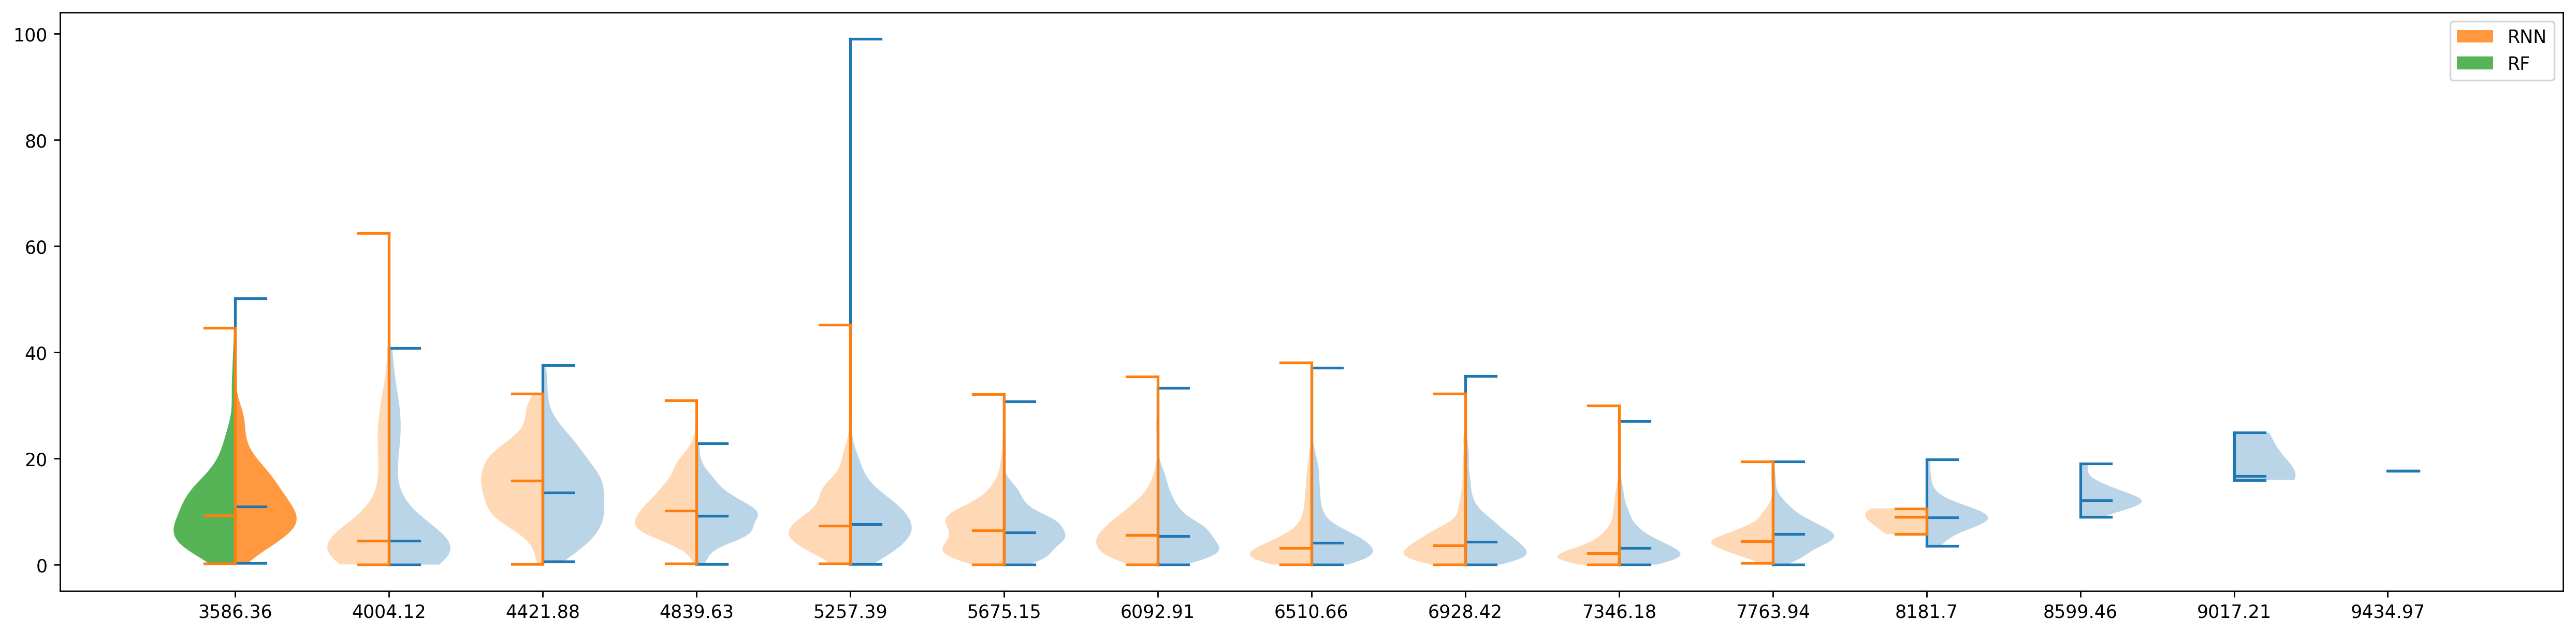

In [46]:

fig, ax = plt.subplots(figsize=(20, 5), dpi=250)
kwargs = {'showextrema':True, 
            'showmedians':True,
          'widths':0.8,
         # 'bw_method':'silverman'
         }
v_rnn = ax.violinplot(dataset=binned_rnn, points=int(1e4), side='high', **kwargs) 
v_rf = ax.violinplot(dataset=binned_rf, points=int(1e4), side='low', **kwargs)
# v_rf = ax.violinplot(dataset=binned_rf, positions=indices_rf, points=int(1e4), side='low', **kwargs)

# Set colors
v_rnn['bodies'][0].set_facecolor('C1')
v_rnn['bodies'][0].set_alpha(0.8)

v_rf['bodies'][0].set_facecolor('C2')
v_rf['bodies'][0].set_alpha(0.8)

# Add legend patches
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='C1', alpha=0.8, label='RNN'),
    Patch(facecolor='C2', alpha=0.8, label='RF')
]
ax.legend(handles=legend_elements)

plt.xticks(ticks=range(1, len(mid_bins)+1), labels=centers, rotation=0)

plt.tight_layout()
plt.show()

In [47]:
binned_rnn

(155003067643847904     8.413373
 79762417627084878     16.677057
 73572629258727296      3.896383
 82452636180910990     12.494910
 114822930346442068    18.709747
                         ...    
 87122369192494096     16.863609
 101680840622389181    10.178622
 182943478138099164     9.132504
 130502857685307779    19.131332
 195690375154112429    26.332691
 Name: p_diff, Length: 165, dtype: float64,
 80572621561908921      4.637763
 105472196797007808    23.821625
 107632836714968667    21.196387
 134622689392237057     1.303082
 191233453629384161    39.417040
                         ...    
 74592716489706642      1.401126
 76212592890564020     28.989855
 189673501687201982     1.719746
 135312918524086756    13.049967
 79682737562318186     20.154650
 Name: p_diff, Length: 112, dtype: float64,
 73782592016211274     19.035052
 84152661661644131     16.906555
 73732616239425002      8.758714
 127283051695078501     2.211103
 83162655656818514     10.642890
                     